In [3]:
import pandas as pd

orders = pd.read_csv('./data/orders.csv')
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
furniture = pd.Series(orders[orders.Category == 'Furniture'].groupby('Order Date').agg('sum')['Quantity']).asfreq("D").fillna(0)
office = pd.Series(orders[orders.Category == 'Office Supplies'].groupby('Order Date').agg('sum')['Quantity']).asfreq("D").fillna(0).rename({"Quantity": "Office"})
technology = pd.Series(orders[orders.Category == 'Technology'].groupby('Order Date').agg('sum')['Quantity'])
technology['2014-01-01'] = 0
technology = technology.asfreq("D").fillna(0).rename({"Quantity": "Technology"})

/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_12034/1993731223.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders['Order Date'] = pd.to_datetime(orders['Order Date'])


In [4]:
furniture.rename({"Quantity": "Furniture"}, inplace=True)
data = pd.concat([office, furniture, technology], axis=1)
data.columns = ['Office', "Furniture", "Technology"]

In [50]:
from sktime.forecasting.var import VAR

model = VAR(maxlags=15, ic='bic')
model_fit = model.fit(data[:-5])

/Users/grigorychaykovsky/retail_forecasts/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Order Date'>

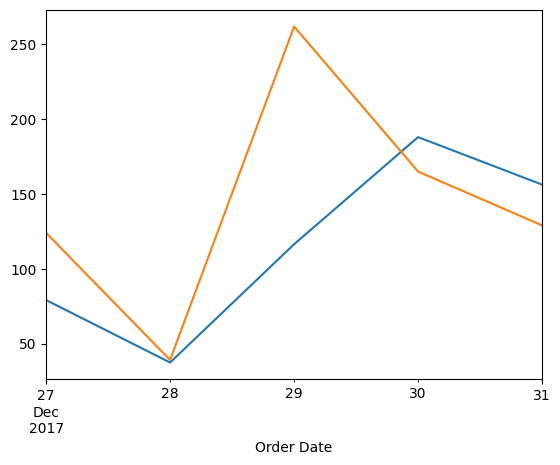

In [51]:
model_fit.predict(fh=[1, 2, 3, 4, 5]).Office.plot()
data[-5:].Office.plot()

In [ ]:
type(model_fit.fitte)

In [52]:
model_fit._fitted_forecaster.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Feb, 2025
Time:                     17:35:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    17.3068
Nobs:                     1449.00    HQIC:                   17.1560
Log likelihood:          -18466.7    FPE:                2.58114e+07
AIC:                      17.0663    Det(Omega_mle):     2.46706e+07
--------------------------------------------------------------------
Results for equation Office
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 6.418710         2.298773            2.792           0.005
L1.Office             0.162166         0.032735            4.954           0.000
L1.Furniture          0.001754         0.079061            

In [10]:
# grid search
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon


maxlags = list(range(1, 15))
param_grid = {"maxlags": maxlags}
fh = ForecastingHorizon([1, 2, 3])
# cv = SlidingWindowSplitter(start_with_window=True, fh=fh, step_length=7, window_length=70)
cv = ExpandingWindowSplitter(initial_window=70, step_length=5, fh=[1, 2, 3])
# cv = SlidingWindowSplitter(initial_window=70, step_length=5, fh=[1, 2, 3])

forecaster = VAR(ic='bic')
grid_searcher = ForecastingGridSearchCV(
    forecaster=forecaster,
    cv=cv,
    param_grid=param_grid,
    # error_score='raise',
    # backend="multiprocessing"
)


In [ ]:
grid_searcher.fit(data)
data.shape

In [12]:
grid_searcher.best_params_

{'maxlags': 10}

In [20]:
grid_searcher.best_forecaster_._fitted_forecaster.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Feb, 2025
Time:                     22:23:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    17.3288
Nobs:                     1454.00    HQIC:                   17.1785
Log likelihood:          -18547.2    FPE:                2.64050e+07
AIC:                      17.0891    Det(Omega_mle):     2.52418e+07
--------------------------------------------------------------------
Results for equation Office
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 6.147283         2.299117            2.674           0.008
L1.Office             0.158613         0.032844            4.829           0.000
L1.Furniture         -0.015833         0.079006           -

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.model_evaluation import evaluate

mape = MeanAbsolutePercentageError(symmetric=False)

cv_results = evaluate(
    forecaster=grid_searcher.best_forecaster_,  
    y=data,
    cv=cv,
    strategy="refit",
    scoring=mape
)

<Axes: >

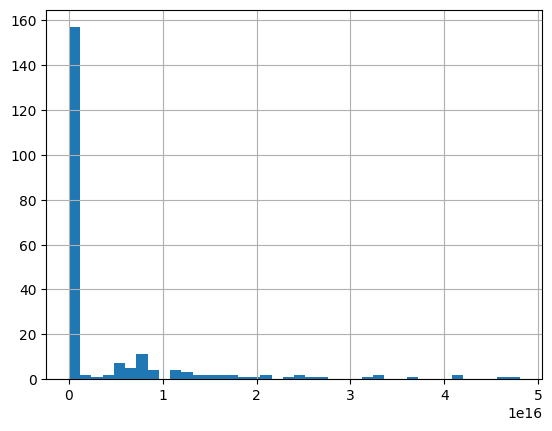

In [32]:
cv_results.test_MeanAbsolutePercentageError.hist(bins=40)

Как видим, в большинстве случаев модель дает относительно разумные предсказания, но иногда, из-за близости исходных значений к нулю, MAPE принимает экстремально большие значения, которые не имеет смысла принимать по внимание